# Use opical flow Farneback method to track objects (human)

In [1]:
import cv2 as cv
import cv2
import matplotlib.pyplot as plt
import numpy as np

### define useful functions

In [ ]:
def remake_seg(seg):
    labels = np.unique(seg)
    for i in range(len(labels)-1):
        lab = labels[i+1]
        mask1 = np.ma.masked_equal(seg, lab)

In [3]:
def water_threshold(mag, frame2):
    bgr = mag*(mag>1)
    kernel = np.ones((15,15),np.float32)
    bgr = cv.morphologyEx(bgr, cv.MORPH_OPEN, kernel)
    img = frame2
    img[...,0] = img[...,0]*(bgr>0)
    img[...,1] = img[...,1]*(bgr>0)
    img[...,2] = img[...,2]*(bgr>0)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv.dilate(opening,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
    ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg,sure_fg)
    # Marker labelling
    ret, markers = cv.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    markers = cv.watershed(img,markers)
    img[markers == -1] = [255,0,0]
    return img

In [4]:
def masked_moving_object_v2(mag,frame,mask0, rate= 1.2, itera=1):
    bgr = mag
    kernel = np.ones((5,5),np.float32)
    #bgr = cv.morphologyEx(bgr, cv.MORPH_OPEN, kernel)
    if itera > 0:
        bgr = cv.erode(bgr,kernel,iterations = itera)
    threshold = np.mean(bgr[bgr>1])*rate
    mask = (bgr>threshold)
    for i in range(3):
        frame[:,:,i] = frame[:,:,i]*mask
    return frame, mask

In [5]:
def masked_moving_object(mag,frame, rate= 1.2, itera=1):
    bgr = mag
    kernel = np.ones((5,5),np.float32)
    if itera > 0:
        bgr = cv.erode(bgr,kernel,iterations = itera)
    threshold = np.mean(bgr[bgr>1])*rate
    mask = (bgr>threshold)*1
    for i in range(3):
        frame[:,:,i] = frame[:,:,i]*mask
    return frame, True

## 1. The original optical flow detection

In [2]:
cap = cv.VideoCapture("test6.mp4")
show_masked = True
ret, frame1 = cap.read()
frame1 = cv2.resize(frame1,(480,320))
prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255
while(1):
    ret, frame2 = cap.read()
    if ret == False:
        break
    frame2 = cv2.resize(frame2,(480,320))
    next_img = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs,next_img, None,
                                        0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
    cv.imshow('frame2',bgr)
    k = cv2.waitKey(5) & 0xff
    prvs = next_img
cap.release()
cv.destroyAllWindows()

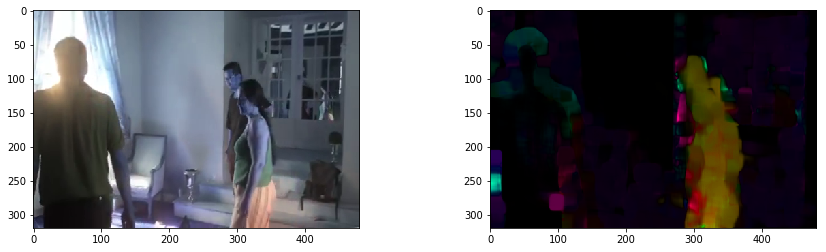

In [16]:
plt.figure(figsize=(15,4))
plt.subplot(121);plt.imshow(frame2)
plt.subplot(122);plt.imshow(bgr)

## 2 Test with maskede color video

In [ ]:
cap = cv.VideoCapture("test6.mp4")
show_masked = True
ret, frame1 = cap.read()
frame1 = cv2.resize(frame1,(480,320))
prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
flow = None
mask = np.zeros((320,480))
bgr = frame1
while(1):
    ret, frame2 = cap.read()
    if ret == False:
        break
    frame2 = cv2.resize(frame2,(480,320))
    next_img = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs,next_img, flow,
                                        0.5, 3, 10, 3, 7, 1.5, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    if np.mean(mag) > 0.15:
        #bgr, _ = masked_moving_object(mag, frame2 ,8 ,2)
        bgr, mask = masked_moving_object_v2(mag, frame2, mask ,0.8 ,0)
    cv2.imshow('frames2', bgr)
    k = cv2.waitKey(5) & 0xff
    prvs = next_img
cap.release()
cv.destroyAllWindows()

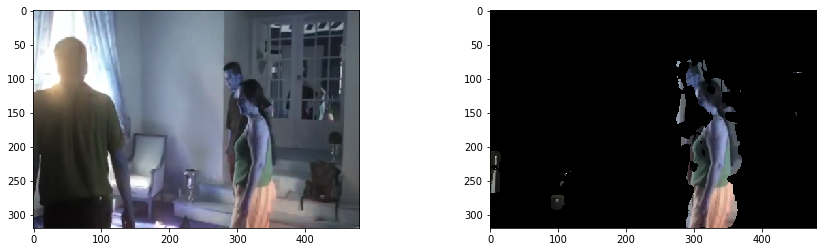

In [20]:
plt.figure(figsize=(15,4))
plt.subplot(121);plt.imshow(frame2)
plt.subplot(122);plt.imshow(bgr)

## 3. Test with water threshold

In [ ]:
cap = cv.VideoCapture("test6.mp4")
show_masked = True
for i in range(40):
    ret, frame1 = cap.read()
frame1 = cv2.resize(frame1,(480,320))
prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
bgr = frame1
while(1):
    ret, frame2 = cap.read()
    if ret == False:
        break
    frame2 = cv2.resize(frame2,(480,320))
    next_img = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs,next_img, None,
                                        0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    #bgr, mask = masked_moving_object_v2(mag, frame2, mask ,1 ,0)
    bgr = water_threshold(mag, frame2)
    cv2.imshow('frames2', bgr)
    k = cv2.waitKey(1) & 0xff
    prvs = next_img
cap.release()
cv.destroyAllWindows()

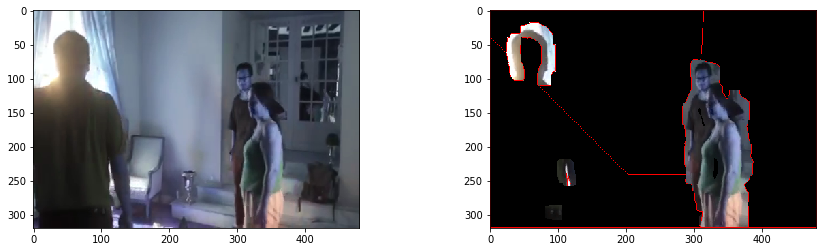

In [18]:
plt.figure(figsize=(15,4))
plt.subplot(121);plt.imshow(frame2)
plt.subplot(122);plt.imshow(bgr)

## test with segmentation
Use graph segmentation to try to seperate different objects

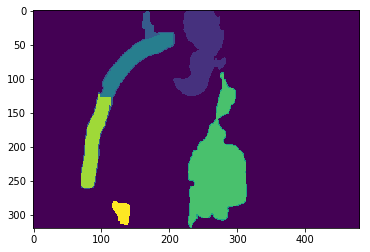

In [300]:
ss = cv2.ximgproc.segmentation.createGraphSegmentation(0.5,300,500)
seg1 = ss.processImage((mag>1)*mag*6)
plt.imshow(seg1)

In [ ]:
cap = cv.VideoCapture("test5.mp4")
show_masked = True
for i in range(40):
    ret, frame1 = cap.read()
frame1 = cv2.resize(frame1,(480,320))
prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
bgr = frame1
hsv = np.zeros_like(frame1)
while(1):
    ret, frame2 = cap.read()
    if ret == False:
        break
    frame2 = cv2.resize(frame2,(480,320))
    next_img = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs,next_img, None,
                                        0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    #bgr, mask = masked_moving_object_v2(mag, frame2, mask ,1 ,0)
    ss = cv2.ximgproc.segmentation.createGraphSegmentation(0.9,300,100)
    seg1 = ss.processImage((mag>2)*mag*6)
    for i in range(3):
        hsv[...,i] = seg1
    cv2.imshow('frames2', hsv*20)
    k = cv2.waitKey(1) & 0xff
    #prvs = next_img
cap.release()
cv.destroyAllWindows()

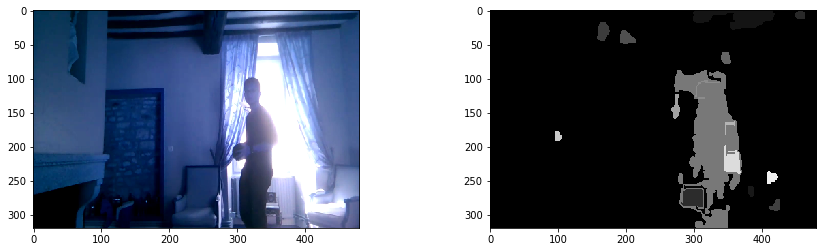

In [12]:
plt.figure(figsize=(15,4))
plt.subplot(121);plt.imshow(frame2)
plt.subplot(122);plt.imshow(hsv*20)